In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import time
from mpl_toolkits.mplot3d import Axes3D 
import scipy
import sys

In [2]:
import gymnasium
from gymnasium import spaces

In [3]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
import autograd, autograd.core, autograd.extend, autograd.tracer  
import autograd.numpy as anp 
from deap import base
from deap import creator
from deap import tools
import random
import seaborn as sns
import gudhi as gd

In [4]:
sys.path.append('../../../ocean_intella/ocean_intella/pipelay_profile_optimization/')

In [5]:
import elitism

In [6]:
x0, y0 = 24, 24

### Finite Element Model

In [7]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
#     print(params)
    return ObjectView(params)

def mbb_beam(width=y0, height=x0, density=1e-4, y=1, x=0, rd=0):  # textbook beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = 1
    return normals, forces, density

In [8]:
def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

In [9]:
def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

In [10]:
def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)

In [11]:
def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])

In [12]:
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]

In [13]:
def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

In [14]:
def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve


def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

In [15]:
def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
#     constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [16]:
def draw(X):  
    plt.figure(dpi=50) 
    print('\nFinal Cantilever beam design:')
    plt.imshow(X) 
    plt.show()

### Genetic Modelling

In [17]:
# Genetic Algorithm constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 2000
HALL_OF_FAME_SIZE = 30

In [18]:
PENALTY_VALUE = 1000.0 

In [19]:
# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [20]:
toolbox = base.Toolbox()

In [21]:
# define a single objective, minimizing fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

In [22]:
# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMin)

In [23]:
# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

In [24]:
# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", 
                 tools.initRepeat,
                 creator.Individual,
                 toolbox.zeroOrOne, 
                 x0*y0+4)

In [25]:
# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", 
                 tools.initRepeat, 
                 list, 
                 toolbox.individualCreator)

In [26]:
# convert a binary list to decimal
def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

In [27]:
class Prev:
    def __init__(self):
        self.prev = 100

In [28]:
T=Prev()

In [29]:
# fitness calculation
def staticFEM(individual):
    
    args = get_args(*mbb_beam(rd=0))
    
    x = np.array([t if t==1 else 1e-4 for t in individual[:-4]]) 
    
    
    try:
        if np.sum(x)/(x0*y0) > 0.5:
            tmp, const = fast_stopt(args, x)
            T.prev=tmp
            if const>(55+binatodeci(individual[-4:]))/100:
                return PENALTY_VALUE, 
        else:
            return T.prev,
    except:
        return PENALTY_VALUE, 
    
    
    return tmp,  # return a tuple

In [30]:
toolbox.register("evaluate", staticFEM)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/(x0*y0+4))

In [31]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # print best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])
    print()
    
    x = np.array(best[:-4]).astype(np.float64).reshape(x0,y0)
    
    args = get_args(*mbb_beam(rd=-1))
    print(fast_stopt(args, x))
    
    draw(x)
    

    # extract statistics:
    minFitnessValues, meanFitnessValues = logbook.select("min", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
  
    plt.xlabel('Generation')
    plt.ylabel('Min / Average Fitness')
    plt.title('Min and Average fitness over Generations')
    plt.show()    
    return x

gen	nevals	min    	avg    
0  	300   	95.0064	2923.25
1  	238   	88.4002	3.28348e+06
2  	248   	88.4002	2431.45    
3  	247   	81.7507	225305     
4  	246   	77.2997	984.656    
5  	250   	77.2997	397.07     
6  	250   	72.3972	169.483    
7  	241   	67.2299	101.712    
8  	248   	62.5417	91.5287    
9  	244   	59.1853	123.845    
10 	243   	58.0257	116.974    
11 	249   	53.9691	163.406    
12 	246   	48.5188	67.4956    
13 	244   	48.5188	69.832     
14 	253   	48.5188	63.0199    
15 	247   	48.1386	76.175     
16 	255   	46.8558	80.3707    
17 	238   	46.5434	97.3727    
18 	247   	45.2256	79.9012    
19 	246   	44.9092	112.979    
20 	228   	44.9092	127.83     
21 	245   	44.3731	120.816    
22 	253   	43.2654	154.874    
23 	241   	43.2654	122.568    
24 	245   	43.2654	131.6      
25 	250   	43.0989	143.824    
26 	245   	42.7684	149.785    
27 	236   	42.1269	143.111    
28 	238   	42.1269	142.775    
29 	238   	41.2076	148.779    
30 	236   	40.9387	132.459    
31 	236   	40.93

264	248   	23.4899	150.552    
265	230   	23.4472	117.997    
266	252   	23.4472	150.522    
267	252   	23.4472	95.1718    
268	255   	23.4472	134.216    
269	237   	23.4084	111.416    
270	247   	23.3937	121.165    
271	249   	23.3702	143.938    
272	244   	23.3702	160.215    
273	237   	23.3367	143.924    
274	241   	23.322 	143.9      
275	252   	23.322 	124.356    
276	248   	23.3002	127.599    
277	247   	23.3002	108.054    
278	245   	23.2858	82.0071    
279	246   	23.2789	127.553    
280	247   	23.2466	147.085    
281	246   	23.2466	143.816    
282	250   	23.2221	195.887    
283	244   	23.2103	111.244    
284	234   	23.2103	134.006    
285	236   	23.1752	104.705    
286	251   	23.1752	120.999    
287	244   	23.175 	146.999    
288	261   	23.1529	130.706    
289	254   	23.1157	120.934    
290	243   	23.0627	137.215    
291	234   	23.0627	133.941    
292	228   	23.0209	117.65     
293	251   	22.9792	127.377    
294	254   	22.9792	62.2532    
295	246   	22.9242	36.148     
296	254 

529	256   	21.5029	181.38     
530	234   	21.5029	135.745    
531	240   	21.4961	132.46     
532	250   	21.4892	178.123    
533	240   	21.454 	142.235    
534	239   	21.4484	129.185    
535	242   	21.4484	155.271    
536	246   	21.4484	148.739    
537	245   	21.4484	171.555    
538	254   	21.4484	151.979    
539	246   	21.4484	161.757    
540	251   	21.4394	161.761    
541	247   	21.4173	165.007    
542	243   	21.4173	168.265    
543	242   	21.4173	132.416    
544	253   	21.4173	148.717    
545	243   	21.4173	145.434    
546	243   	21.4173	161.747    
547	247   	21.4155	168.259    
548	247   	21.4155	164.987    
549	244   	21.4155	135.628    
550	240   	21.4039	129.109    
551	249   	21.4039	148.706    
552	248   	21.4039	119.359    
553	244   	21.4039	148.682    
554	253   	21.4039	129.11     
555	241   	21.4039	164.981    
556	248   	21.4039	112.786    
557	245   	21.4039	135.609    
558	255   	21.4039	96.4616    
559	255   	21.4039	155.169    
560	246   	21.4019	116.038    
561	246 

794	241   	21.1775	50.5964    
795	238   	21.1775	44.0248    
796	239   	21.1775	34.2413    
797	243   	21.1775	37.4971    
798	257   	21.1775	30.9932    
799	247   	21.1775	50.5594    
800	256   	21.1775	37.5122    
801	248   	21.1775	37.4978    
802	249   	21.1775	37.5115    
803	246   	21.1775	37.4977    
804	243   	21.172 	37.5059    
805	249   	21.172 	40.7994    
806	235   	21.172 	34.2727    
807	261   	21.172 	57.0787    
808	239   	21.172 	50.585     
809	246   	21.172 	66.8749    
810	239   	21.172 	53.8117    
811	253   	21.172 	63.6022    
812	236   	21.172 	57.0831    
813	243   	21.172 	57.111     
814	244   	21.172 	102.788    
815	246   	21.172 	89.7045    
816	263   	21.172 	99.5005    
817	254   	21.172 	86.4587    
818	245   	21.172 	112.553    
819	245   	21.172 	92.9694    
820	245   	21.172 	66.8716    
821	255   	21.172 	57.1148    
822	242   	21.172 	47.2878    
823	245   	21.172 	53.8091    
824	246   	21.1718	57.0887    
825	251   	21.1718	57.0704    
826	239 

1057	252   	21.1366	40.7637    
1058	235   	21.1366	40.7215    
1059	239   	21.1366	44.0003    
1060	244   	21.1366	47.2825    
1061	246   	21.1366	37.459     
1062	243   	21.1366	50.518     
1063	251   	21.1366	37.4665    
1064	238   	21.1366	47.2452    
1065	250   	21.1366	40.7299    
1066	238   	21.1366	37.4571    
1067	242   	21.1366	47.2455    
1068	252   	21.1366	37.4566    
1069	250   	21.1366	34.1987    
1070	236   	21.1366	37.4592    
1071	241   	21.1366	34.2272    
1072	253   	21.1366	43.9959    
1073	245   	21.1366	40.7156    
1074	249   	21.1366	34.207     
1075	238   	21.1366	47.2442    
1076	241   	21.1366	27.6872    
1077	240   	21.1366	40.7265    
1078	245   	21.1366	43.9816    
1079	248   	21.1366	34.1948    
1080	240   	21.1366	50.5122    
1081	239   	21.1366	47.2766    
1082	240   	21.1366	47.2455    
1083	242   	21.1366	47.2494    
1084	244   	21.1366	40.72      
1085	245   	21.1366	40.7172    
1086	243   	21.1366	53.7731    
1087	233   	21.1366	47.2467    
1088	246

1314	251   	21.1366	53.7727    
1315	253   	21.1366	53.7712    
1316	238   	21.1366	47.2604    
1317	225   	21.1366	60.2952    
1318	257   	21.1366	57.0742    
1319	245   	21.1366	47.2518    
1320	255   	21.1366	40.72      
1321	257   	21.1366	50.5099    
1322	254   	21.1366	40.7363    
1323	247   	21.1366	47.262     
1324	238   	21.1366	43.9829    
1325	237   	21.1366	43.988     
1326	255   	21.1366	37.4795    
1327	244   	21.1366	40.7206    
1328	256   	21.1366	60.2998    
1329	250   	21.1366	47.2505    
1330	250   	21.1366	47.259     
1331	239   	21.1366	57.054     
1332	229   	21.1366	57.0371    
1333	241   	21.1366	47.2481    
1334	247   	21.1366	60.2999    
1335	250   	21.1366	47.2525    
1336	243   	21.1366	34.2056    
1337	242   	21.1366	53.7819    
1338	250   	21.1366	47.2513    
1339	242   	21.1366	37.4607    
1340	238   	21.1366	37.4561    
1341	239   	21.1366	47.2463    
1342	232   	21.1366	50.525     
1343	249   	21.1366	53.8148    
1344	242   	21.1366	50.5178    
1345	250

1571	243   	21.1366	50.5493    
1572	248   	21.1366	47.2544    
1573	249   	21.1366	43.9948    
1574	249   	21.1366	34.2065    
1575	250   	21.1366	30.9455    
1576	244   	21.1366	40.7388    
1577	239   	21.1366	53.7744    
1578	237   	21.1366	40.7523    
1579	243   	21.1366	53.7707    
1580	246   	21.1366	53.778     
1581	256   	21.1366	40.7313    
1582	237   	21.1366	27.6663    
1583	239   	21.1366	30.9307    
1584	241   	21.1366	43.9865    
1585	239   	21.1366	34.1992    
1586	243   	21.1366	34.1933    
1587	250   	21.1366	37.465     
1588	244   	21.1366	34.1999    
1589	242   	21.1366	43.9878    
1590	258   	21.1366	40.7282    
1591	237   	21.1366	34.1992    
1592	251   	21.1366	37.4635    
1593	236   	21.1366	34.1924    
1594	255   	21.1366	37.4583    
1595	246   	21.1366	57.0397    
1596	223   	21.1366	43.9927    
1597	246   	21.1366	34.1955    
1598	245   	21.1366	34.2042    
1599	241   	21.1366	40.7177    
1600	234   	21.1366	34.2126    
1601	230   	21.1366	34.2166    
1602	253

1828	238   	21.1212	76.6347    
1829	245   	21.1212	60.2837    
1830	246   	21.1212	60.2905    
1831	256   	21.1212	53.759     
1832	240   	21.1212	37.4405    
1833	247   	21.1212	47.2316    
1834	253   	21.1212	37.4462    
1835	251   	21.1212	47.2326    
1836	244   	21.1212	53.7575    
1837	228   	21.1212	50.4986    
1838	249   	21.1212	40.7023    
1839	242   	21.1212	37.4435    
1840	245   	21.1212	50.496     
1841	248   	21.1212	34.194     
1842	242   	21.1212	40.7248    
1843	249   	21.1212	27.6827    
1844	246   	21.1212	30.9522    
1845	252   	21.1212	34.1858    
1846	234   	21.1212	37.4529    
1847	254   	21.1212	30.9296    
1848	252   	21.1212	40.7079    
1849	245   	21.1212	40.7499    
1850	252   	21.1212	37.4477    
1851	244   	21.1212	30.9207    
1852	243   	21.1212	43.9994    
1853	243   	21.1212	43.9668    
1854	249   	21.1212	73.3456    
1855	238   	21.1212	40.7119    
1856	256   	21.1212	40.7074    
1857	257   	21.1212	50.4933    
1858	242   	21.1212	50.5178    
1859	253

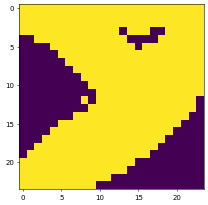

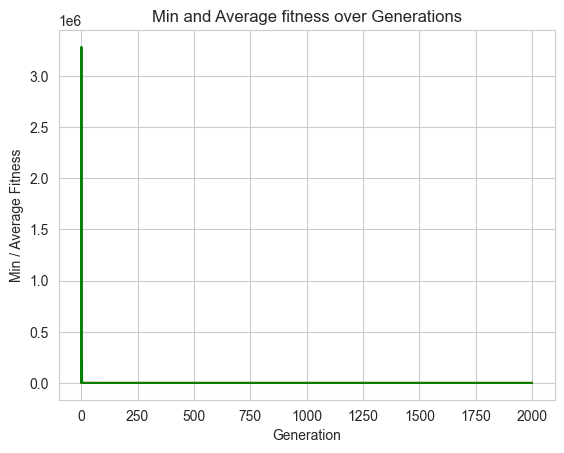

In [32]:
start = time.time()
top_ = main()
end = time.time() 

### RL model

In [33]:
class Model:
    def __init__(self, x):
        self.flag_ = True
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                self.actions_dic[k]=(i,j)
                k+=1
        
    def action_space_(self, action, X):
        x,y=self.actions_dic[action]
        X[x][y]=1

In [34]:
class CantileverEnv(gymnasium.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self,x1,y1):
        super().__init__()
        self.x0=x1
        self.y0=y1
        
        DIM =  self.x0 * self.y0
        N_DISCRETE_ACTIONS = self.x0 * self.y0
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
        self.x = np.zeros(( self.x0, self.y0))
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        self.ext_reward=0

        
    def step(self, action):
        
        self.M.action_space_(action, self.x)        
        self.step_+=1
               
        done=False
                  
        if self.step_ > 0.8 * self.x0 * self.y0:
            done=True            
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
        
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.ext_reward, done, False, dict()

    def reset(self, seed=0):
                   
        self.x = np.zeros((self.x0, self.y0))

        self.reward = 0
        self.needs_reset = False
        self.step_ = 0
        self.ext_reward = 0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        pass   

    def close(self):
        pass

In [35]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            
            
            
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")

            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                
                mean_reward = np.mean(y[-100:])
                
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [36]:
def reconstruct_3d_structure(xy_plane, yz_plane, xz_plane):
    """
    Reconstructs a 3D structure from three 2D projections using extrusion and intersection.

    Parameters:
        xy_plane (ndarray): 2D binary array (X by Y) projection in XY plane.
        yz_plane (ndarray): 2D binary array (Y by Z) projection in YZ plane.
        xz_plane (ndarray): 2D binary array (X by Z) projection in XZ plane.

    Returns:
        volume (ndarray): 3D binary array (X by Y by Z) representing the reconstructed structure.
    """
    x_dim, y_dim = xy_plane.shape
    y_dim2, z_dim = yz_plane.shape
    x_dim2, z_dim2 = xz_plane.shape

    assert x_dim == x_dim2, "X dimensions mismatch between XY and XZ planes."
    assert y_dim == y_dim2, "Y dimensions mismatch between XY and YZ planes."
    assert z_dim == z_dim2, "Z dimensions mismatch between YZ and XZ planes."

    # Extrude XY along Z
    xy_extruded = np.repeat(xy_plane[:, :, np.newaxis], z_dim, axis=2)

    # Extrude YZ along X
    yz_extruded = np.repeat(yz_plane[np.newaxis, :, :], x_dim, axis=0)

    # Extrude XZ along Y
    xz_extruded = np.repeat(xz_plane[:, np.newaxis, :], y_dim, axis=1)

    # Intersect all three extrusions
    volume = xy_extruded & yz_extruded & xz_extruded

    return volume.astype(np.uint8)  # or bool, depending on your needs

In [37]:
def deconstruct(grid, topology, location):
    gr = grid.copy()
    row_offset = (location // 4) * x0//4
    col_offset = (location % 4) * x0//4
    gr[row_offset:row_offset+x0//4, col_offset:col_offset+x0//4] = topology
    return gr

In [38]:
def count_islands_dfs(grid):
    """
    Calculates the number of islands in a 2D binary grid using Depth First Search (DFS).

    An island is formed by connected 1's (horizontally/vertically adjacent).
    
    Args:
        grid (list of lists): A 2D matrix with values 0 or 1.

    Returns:
        int: The total number of islands found.
    """
#     if not grid or not grid[0]:
#         return 0
    
    rows = len(grid)
    cols = len(grid[0])
    visited = set()
    island_count = 0

    def dfs(r, c):
        """Helper function to traverse and mark a single island as visited."""
        # Check boundary conditions and if the cell has already been visited or is water (0)
        if r < 0 or r >= rows or c < 0 or c >= cols or grid[r][c] == 0 or (r, c) in visited:
            return
        
        visited.add((r, c))
        
        # Recursively visit all adjacent cells (up, down, left, right)
        dfs(r + 1, c) # Down
        dfs(r - 1, c) # Up
        dfs(r, c + 1) # Right
        dfs(r, c - 1) # Left

    # Iterate through every cell in the grid
    for r in range(rows):
        for c in range(cols):
            # If we find land (1) that hasn't been visited yet, 
            # it means we've found the start of a new island.
            if grid[r][c] == 1 and (r, c) not in visited:
                island_count += 1
                # Start DFS from this point to mark all parts of this island
                dfs(r, c)
                
    return island_count

In [39]:
def calculate_smoothness_metric(binary_matrix):
    """
    Calculates a smoothness metric for a 2D binary matrix.
    Lower values indicate greater smoothness. A value of 0 means 
    the image is perfectly uniform or has only linear transitions.

    The metric is the sum of differences between a pixel and its
    right and bottom neighbors, effectively counting vertical and
    horizontal edges.

    Args:
        binary_matrix (list of lists or numpy array): A 2D matrix 
                                                     with values 0 or 1.

    Returns:
        int: The total count of horizontal and vertical transitions.
    """
    # Convert to a numpy array for efficient processing
    matrix = np.array(binary_matrix, dtype=int)
    h, w = matrix.shape
    
    # Calculate absolute differences for horizontal transitions
    # We slice the matrix to compare each element with its right neighbor
    horizontal_diffs = np.abs(matrix[:, :w-1] - matrix[:, 1:])
    
    # Calculate absolute differences for vertical transitions
    # We slice the matrix to compare each element with its bottom neighbor
    vertical_diffs = np.abs(matrix[:h-1, :] - matrix[1:, :])
    
    # The sum of these differences gives the total number of transitions (edges)
    total_transitions = np.sum(horizontal_diffs) + np.sum(vertical_diffs)
    
    return int(total_transitions)

In [40]:
class CrossRewardEnv(gymnasium.Env):
    def __init__(self):
        super().__init__()
        self.env0 = CantileverEnv(x0//4,y0//4)
        self.env1 = CantileverEnv(x0//4,y0//4)
        self.env2 = CantileverEnv(x0//4,y0//4)
        self.env3 = CantileverEnv(x0//4,y0//4)
        self.env4 = CantileverEnv(x0//4,y0//4)
        self.env5 = CantileverEnv(x0//4,y0//4)
        self.env6 = CantileverEnv(x0//4,y0//4)
        self.env7 = CantileverEnv(x0//4,y0//4)
        self.env8 = CantileverEnv(x0//4,y0//4)
        self.env9 = CantileverEnv(x0//4,y0//4)
        self.env10 = CantileverEnv(x0//4,y0//4)
        self.env11 = CantileverEnv(x0//4,y0//4)
        self.env12 = CantileverEnv(x0//4,y0//4)
        self.env13 = CantileverEnv(x0//4,y0//4)
        self.env14 = CantileverEnv(x0//4,y0//4)
        self.env15 = CantileverEnv(x0//4,y0//4)

        self.observation_space = spaces.Dict({
            'plane0': self.env0.observation_space,
            'plane1': self.env1.observation_space,
            'plane2': self.env2.observation_space,
            'plane3': self.env3.observation_space,
            'plane4': self.env4.observation_space,
            'plane5': self.env5.observation_space,
            'plane6': self.env6.observation_space,
            'plane7': self.env7.observation_space,
            'plane8': self.env8.observation_space,
            'plane9': self.env9.observation_space,
            'plane10': self.env10.observation_space,
            'plane11': self.env11.observation_space,
            'plane12': self.env12.observation_space,
            'plane13': self.env13.observation_space,
            'plane14': self.env14.observation_space,
            'plane15': self.env15.observation_space,
        })

        self.action_space = spaces.MultiDiscrete([x0*y0//16 for i in range(16)])
        self.step1_=0
        self.grid = top_.copy()
        
    def reset(self,seed=0):
        obs0, info0 = self.env0.reset()
        obs1, info1 = self.env1.reset()
        obs2, info2 = self.env2.reset()
        obs3, info3 = self.env3.reset()
        obs4, info4 = self.env4.reset()
        obs5, info5 = self.env5.reset()
        obs6, info6 = self.env6.reset()
        obs7, info7 = self.env7.reset()
        obs8, info8 = self.env8.reset()
        obs9, info9 = self.env9.reset()
        obs10, info10 = self.env10.reset()
        obs11, info11 = self.env11.reset()
        obs12, info12 = self.env12.reset()
        obs13, info13 = self.env13.reset()
        obs14, info14 = self.env14.reset()
        obs15, info15 = self.env15.reset()
        self.step1_=0
        self.grid = top_.copy()
        return {
            'plane0': obs0,
            'plane1': obs1,
            'plane2': obs2,
            'plane3': obs3,
            'plane4': obs4,
            'plane5': obs5,
            'plane6': obs6,
            'plane7': obs7,
            'plane8': obs8,
            'plane9': obs9,
            'plane10': obs10,
            'plane11': obs11,
            'plane12': obs12,
            'plane13': obs13,
            'plane14': obs14,
            'plane15': obs15,
        }, {
            'plane0': info0,
            'plane1': info1,
            'plane2': info2,
            'plane3': info3,
            'plane4': info4,
            'plane5': info5,
            'plane6': info6,
            'plane7': info7,
            'plane8': info8,
            'plane9': info9,
            'plane10': info10,
            'plane11': info11,
            'plane12': info12,
            'plane13': info13,
            'plane14': info14,
            'plane15': info15,
        }

    def step(self, action):
        a0 = action[0]
        a1 = action[1]
        a2 = action[2]
        a3 = action[3]
        a4 = action[4]
        a5 = action[5]
        a6 = action[6]
        a7 = action[7]
        a8 = action[8]
        a9 = action[9]
        a10 = action[10]
        a11 = action[11]
        a12 = action[12]
        a13 = action[13]
        a14 = action[14]
        a15 = action[15]
        
        
        obs0, r0, done0,_, info0 = self.env0.step(a0)
        obs1, r1, done1,_, info1 = self.env1.step(a1)
        obs2, r2, done2,_, info2 = self.env2.step(a2)
        obs3, r3, done3,_, info3 = self.env3.step(a3)
        obs4, r4, done4,_, info4 = self.env4.step(a4)
        obs5, r5, done5,_, info5 = self.env5.step(a5)
        obs6, r6, done6,_, info6 = self.env6.step(a6)
        obs7, r7, done7,_, info7 = self.env7.step(a7)
        obs8, r8, done8,_, info8 = self.env8.step(a8)
        obs9, r9, done9,_, info9 = self.env9.step(a9)
        obs10, r10, done10,_, info10 = self.env10.step(a10)
        obs11, r11, done11,_, info11 = self.env11.step(a11)
        obs12, r12, done12,_, info12 = self.env12.step(a12)
        obs13, r13, done13,_, info13 = self.env13.step(a13)
        obs14, r14, done14,_, info14 = self.env14.step(a14)
        obs15, r15, done15,_, info15 = self.env15.step(a15)
       
        OBS=[obs0,obs1,obs2,obs3,obs4,obs5,obs6,obs7,obs8,obs9,obs10,obs11,obs12,obs13,obs14,obs15]    
        
        REW = []
#         FL = False
#         done = False
        
        for i in range(len(OBS)):
            gr = deconstruct(self.grid, OBS[i].reshape(x0//4,y0//4), i)
            constI=np.sum(gr)/(x0*y0)
         
            if constI>0.65:
                self.args = get_args(*mbb_beam(rd=0))
                self.tmp, self.const = fast_stopt(self.args, gr.astype(float))
#                 reward = 1/self.tmp+1/calculate_smoothness_metric(gr.reshape(x0, y0))
                reward = 1/self.tmp
                if count_islands_dfs(gr)==1:
                    reward*=10
#                 FL=True    
            else:
                reward=0
            REW.append(reward)
            
#         if FL:
#             done = True
            
        self.step1_+=1
        
        RE=np.mean(REW)
        self.env0.ext_reward=RE
        self.env1.ext_reward=RE
        self.env2.ext_reward=RE
        self.env3.ext_reward=RE
        self.env4.ext_reward=RE
        self.env5.ext_reward=RE
        self.env6.ext_reward=RE
        self.env7.ext_reward=RE
        self.env8.ext_reward=RE
        self.env9.ext_reward=RE
        self.env10.ext_reward=RE
        self.env11.ext_reward=RE
        self.env12.ext_reward=RE
        self.env13.ext_reward=RE
        self.env14.ext_reward=RE
        self.env15.ext_reward=RE
        
        done = (done0 or done1 or done2 or done3 or done4 or done5 or done6 or
        done7 or done8 or done9 or done10 or done11 or done12 or done13 or
        done14 or done15)
        
        return {
             'plane0': obs0,
            'plane1': obs1,
            'plane2': obs2,
            'plane3': obs3,
            'plane4': obs4,
            'plane5': obs5,
            'plane6': obs6,
            'plane7': obs7,
            'plane8': obs8,
            'plane9': obs9,
            'plane10': obs10,
            'plane11': obs11,
            'plane12': obs12,
            'plane13': obs13,
            'plane14': obs14,
            'plane15': obs15,
        }, np.mean(REW), done, False, {
            'plane0':info0,
            'plane1':info1,
            'plane2': info2,
            'plane3': info3,
            'plane4': info4,
            'plane5': info5,
            'plane6': info6,
            'plane7': info7,
            'plane8': info8,
            'plane9': info9,
            'plane10': info10,
            'plane11': info11,
            'plane12': info12,
            'plane13': info13,
            'plane14': info14,
            'plane15': info15,
        }

    def render(self, mode='human'):    
        pass

    def close(self):
        self.env0.close()
        self.env1.close()
        self.env2.close()
        self.env3.close()
        self.env4.close()
        self.env5.close()
        self.env6.close()
        self.env7.close()
        self.env8.close()
        self.env9.close()
        self.env10.close()
        self.env11.close()
        self.env12.close()
        self.env13.close()
        self.env14.close()
        self.env15.close()

### Training 

In [41]:
ts = 0.5e6

In [42]:
# Create log dir
log_dir = "/tmp/gym7_v3afsklnsef/"
os.makedirs(log_dir, exist_ok=True)

In [43]:
callback = SaveOnBestTrainingRewardCallback(check_freq=50_000, log_dir=log_dir)

In [44]:
env=CrossRewardEnv()
check_env(env)
env  = Monitor(env, log_dir)

In [45]:
start = time.time()
model = PPO("MultiInputPolicy", env).learn(total_timesteps=ts, callback=callback)
end = time.time()  

Num timesteps: 50000
Best mean reward: -inf - Last mean reward per episode: 1.09
Saving new best model to /tmp/gym7_v3afsklnsef/best_model.zip
Num timesteps: 100000
Best mean reward: 1.09 - Last mean reward per episode: 1.16
Saving new best model to /tmp/gym7_v3afsklnsef/best_model.zip
Num timesteps: 150000
Best mean reward: 1.16 - Last mean reward per episode: 1.56
Saving new best model to /tmp/gym7_v3afsklnsef/best_model.zip
Num timesteps: 200000
Best mean reward: 1.56 - Last mean reward per episode: 1.75
Saving new best model to /tmp/gym7_v3afsklnsef/best_model.zip
Num timesteps: 250000
Best mean reward: 1.75 - Last mean reward per episode: 2.03
Saving new best model to /tmp/gym7_v3afsklnsef/best_model.zip
Num timesteps: 300000
Best mean reward: 2.03 - Last mean reward per episode: 1.98
Num timesteps: 350000
Best mean reward: 2.03 - Last mean reward per episode: 1.92
Num timesteps: 400000
Best mean reward: 2.03 - Last mean reward per episode: 1.91
Num timesteps: 450000
Best mean rew

In [46]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 558.6213884989421 min


### Inference

In [47]:
def construct(OBS):
    grid = np.zeros((x0, y0), dtype=int)
    for i in range(len(OBS)):
        row_offset = (i // 4) * x0//4
        col_offset = (i % 4) * x0//4
        grid[row_offset:row_offset+x0//4, col_offset:col_offset+x0//4] = OBS[i]
    return grid 

In [48]:
obs = env.reset()

In [49]:
obs = obs[0]

In [50]:
i=0
ans=[]
while i < 1000:
    action, _states = model.predict(obs)
    obs, rewards, dones, _, info = env.step(action)
    ans.append(obs)
    if dones:
        break
    i+=1

In [51]:
OBS=[ans[-1]['plane0'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane1'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane2'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane3'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane4'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane5'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane6'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane7'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane8'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane9'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane10'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane11'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane12'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane13'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane14'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane15'].astype(np.uint8).reshape(x0//4,y0//4)]


grid = construct(OBS)


Final Cantilever beam design:


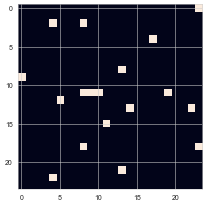

In [52]:
draw(grid)

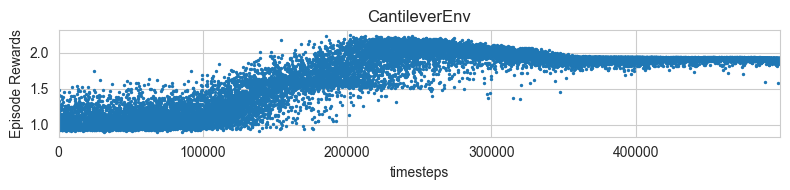

In [53]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [54]:
obs = env.reset()

In [55]:
obs = obs[0]

In [56]:
model_best = PPO.load(log_dir + "best_model.zip", env = env)

In [57]:
i=0
ans=[]
while i<1000:
    action, _states = model_best.predict(obs)
    obs, rewards, dones, _ , info = env.step(action)
    ans.append(obs)
    if dones:
        break
    
    i+=1

In [58]:
OBS=[ans[-1]['plane0'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane1'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane2'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane3'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane4'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane5'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane6'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane7'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane8'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane9'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane10'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane11'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane12'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane13'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane14'].astype(np.uint8).reshape(x0//4,y0//4),
     ans[-1]['plane15'].astype(np.uint8).reshape(x0//4,y0//4)]


grid = construct(OBS)


Final Cantilever beam design:


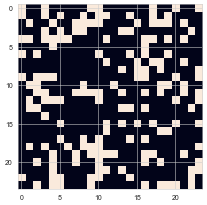

In [59]:
draw(grid)

In [60]:
args = get_args(*mbb_beam(rd=0))
tmp, const = fast_stopt(args, grid.astype(float))

In [61]:
tmp

1224.2483893200929

In [62]:
const

0.2829861111111111

In [63]:
grid

array([[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 1],
       [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0,
        0, 0],
       [0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
        0, 0],
       [0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0],
       [1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
        0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0],
       [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
        0, 1],
       [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 1],
       [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
        0, 0],
       [0, 0, 1, 1, 0

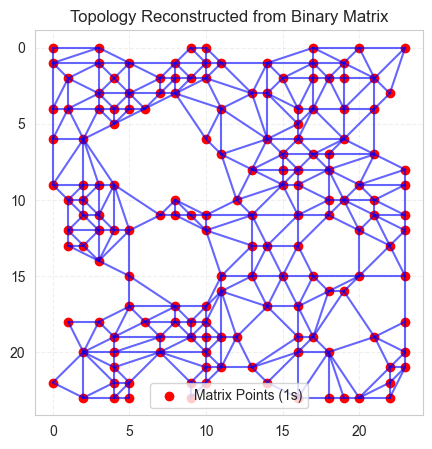

Topological Features found:
Hole/Loop exists from radius 2.25 to 10.18595041322314
Hole/Loop exists from radius 1.25 to 8.876731301939055
Hole/Loop exists from radius 2.0 to 4.722222222222227
Hole/Loop exists from radius 2.25 to 4.722222222222228
Hole/Loop exists from radius 1.25 to 3.611111111111112
Hole/Loop exists from radius 2.0 to 4.0625
Hole/Loop exists from radius 2.5 to 4.420000000000005
Hole/Loop exists from radius 1.0 to 2.5000000000000004
Hole/Loop exists from radius 3.25 to 4.56611570247934
Hole/Loop exists from radius 1.25 to 2.5000000000000004
Hole/Loop exists from radius 1.25 to 2.5000000000000004
Hole/Loop exists from radius 1.25 to 2.5
Hole/Loop exists from radius 2.0 to 3.125
Hole/Loop exists from radius 2.25 to 3.25
Hole/Loop exists from radius 1.0 to 2.0
Hole/Loop exists from radius 2.25 to 3.25
Hole/Loop exists from radius 2.5 to 3.125
Hole/Loop exists from radius 1.0 to 1.5625
Hole/Loop exists from radius 1.0 to 1.5625
Hole/Loop exists from radius 2.0 to 2.5000000

In [64]:
# 1. Convert Matrix to Point Cloud
# np.argwhere finds indices where value is 1
points = np.argwhere(grid == 1)

# 2. Build the Alpha Complex
# This reconstructs the topological structure from the discrete points
alpha_complex = gd.AlphaComplex(points=points)
simplex_tree = alpha_complex.create_simplex_tree()

# 3. Visualization
plt.figure(figsize=(5, 5))

# Plot the original matrix points
plt.scatter(points[:, 1], points[:, 0], c='red', label='Matrix Points (1s)')

# Reconstruct and plot the edges (1-simplices)
# Adjust alpha_threshold to "connect" points at different distances
alpha_threshold = 4 
for simplex, filtration in simplex_tree.get_skeleton(1):
    if len(simplex) == 2 and filtration < alpha_threshold:
        p1, p2 = points[simplex[0]], points[simplex[1]]
        # Note: argwhere returns (row, col), so we plot (col, row) for (x, y)
        plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-', alpha=0.6)

plt.gca().invert_yaxis() # Match matrix coordinate system (top-down)
plt.title("Topology Reconstructed from Binary Matrix")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# 4. Extract Topological Invariants
persistence = simplex_tree.persistence()
print("Topological Features found:")
for dim, (birth, death) in persistence:
    feature_type = "Component" if dim == 0 else "Hole/Loop"
    print(f"{feature_type} exists from radius {birth} to {death}")